In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import KDTree
from scipy.stats import binned_statistic_2d
from pathlib import Path
from matplotlib import animation, rc

/tmp/ipykernel_2992/2402747017.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


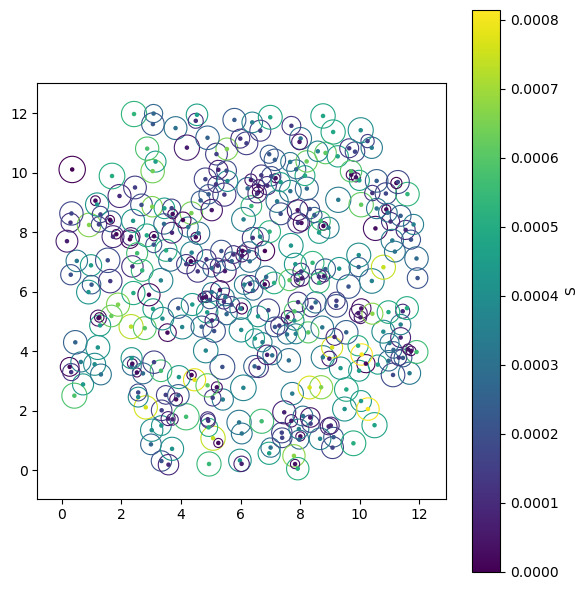

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# --- load data ---
# columns: x, y, (maybe something), s00, s01, s11  (uses 3,4,5 as shape entries)
data = np.loadtxt("particles2d.txt")
data = data[np.isfinite(data).all(axis=1)]  # filter NaNs

# shape matrices Σ
shape = np.zeros((data.shape[0], 2, 2), dtype=float)
shape[:,0,0] = data[:,3]
shape[:,0,1] = data[:,4]
shape[:,1,0] = data[:,4]
shape[:,1,1] = data[:,5]

# color by your S (rename the label accordingly)
# (your S looked like a deviatoric log-shape; keep as-is to stay minimal)
# safer eigendecomp for symmetric matrices:
eigvals, eigvecs = np.linalg.eigh(shape)  # ascending λ
# (optional) a scalar to color by; reuse your formula:
S = 0.5*np.log(eigvals[:,1]) - 0.25*np.log(eigvals[:,0]*eigvals[:,1])

# plot
fig, ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal', adjustable='box')

norm = Normalize(vmin=np.min(S), vmax=np.max(S))
cmap = cm.get_cmap('viridis')

k = 1.0  # scale of contour: 1.0 ~ "1-sigma" if Σ is covariance
for i in range(shape.shape[0]):
    x, y = data[i,0], data[i,1]

    # sort so major axis first
    lam0, lam1 = eigvals[i,1], eigvals[i,0]  # eigh is ascending
    vec0 = eigvecs[i,:,1]                    # eigenvector for lam0 (major)

    # ellipse width/height are full diameters (2*a, 2*b)
    width  = 2.0 * k * np.sqrt(lam0)
    height = 2.0 * k * np.sqrt(lam1)

    # angle from eigenvector of largest eigenvalue
    angle_deg = np.degrees(np.arctan2(vec0[1], vec0[0]))

    e = Ellipse((x, y), width, height, angle=angle_deg,
                facecolor='none',
                edgecolor=cmap(norm(S[i])),
                linewidth=0.8)
    ax.add_patch(e)

# optional scatter of centers (tiny) for reference
ax.scatter(data[:,0], data[:,1], c=S, s=5, cmap=cmap, norm=norm)

mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = plt.colorbar(mappable, ax=ax)
cbar.set_label("S")

plt.tight_layout()
plt.show()


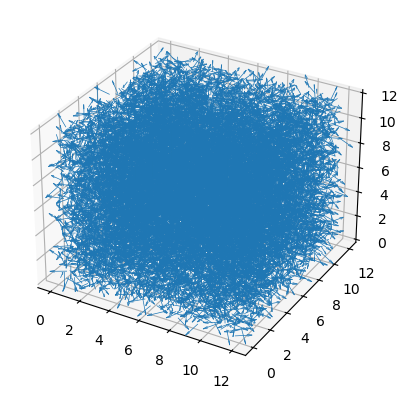

In [2]:
data = np.loadtxt("particles.txt")
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(data[:,0], data[:,1], data[:,2], data[:,3], data[:,4], data[:,5], length=1, lw=.5)
#ax.scatter(data[:,0], data[:,1], data[:,2], s=1)
plt.show()

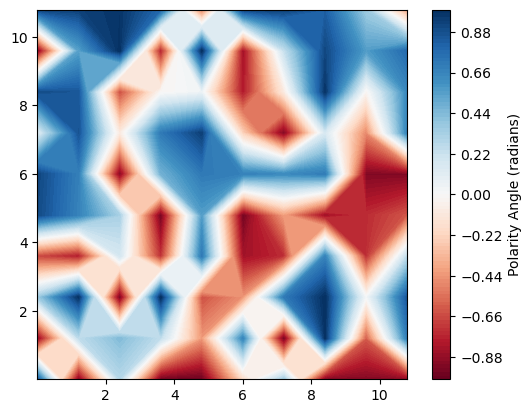

In [3]:

pol_x, bins_x, bins_y, _ = binned_statistic_2d(data[:,0], data[:,1], data[:, 3], bins=10)
pol_y, bins_x, bins_y, _ = binned_statistic_2d(data[:,0], data[:,1], data[:, 4], bins=10)
plt.contourf(bins_x[:-1], bins_y[:-1], np.sin(np.arctan2(pol_y.T, pol_x.T)), levels=100, cmap='RdBu', vmin=-1, vmax=1)
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(label='Polarity Angle (radians)')

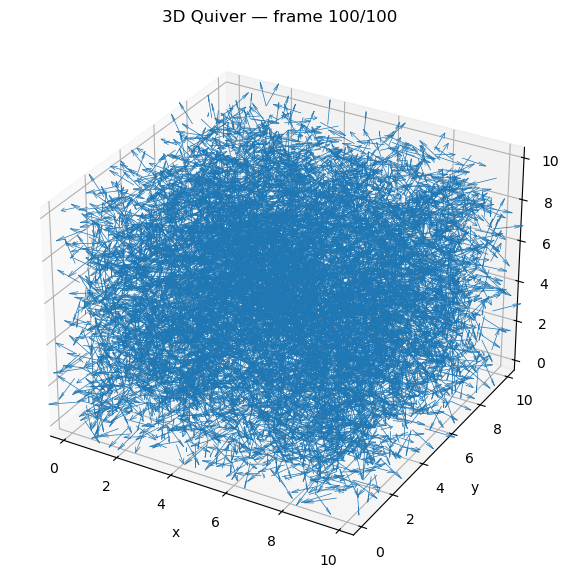

In [2]:
%matplotlib inline
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (activates 3D)

# --- Load frames exactly like you had ---
files = sorted(Path("movies").glob("particles_*.txt"))
frames = [np.loadtxt(f) for i,f in enumerate(files) if i % 2 == 0]     # each frame: N x 6 (x,y,z,u,v,w)

# Keep only needed columns
P = [a[:, :3] for a in frames]              # positions
V = [a[:, 3:6] for a in frames]             # vectors

# --- Axes limits computed once (from positions) ---
allP = np.vstack(P)
pad = 0.05 * (allP.max(axis=0) - allP.min(axis=0)).max()
xmin, ymin, zmin = allP.min(axis=0) - pad
xmax, ymax, zmax = allP.max(axis=0) + pad

# --- Figure ---
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax); ax.set_zlim(zmin, zmax)
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z'); ax.set_title('3D Quiver')

# Helper: equal aspect in 3D
def set_equal_3d(ax):
    x_mid = (xmin + xmax) / 2; y_mid = (ymin + ymax) / 2; z_mid = (zmin + zmax) / 2
    max_range = max(xmax - xmin, ymax - ymin, zmax - zmin) / 2
    ax.set_xlim(x_mid - max_range, x_mid + max_range)
    ax.set_ylim(y_mid - max_range, y_mid + max_range)
    ax.set_zlim(z_mid - max_range, z_mid + max_range)

set_equal_3d(ax)

# --- Create a quiver Artist (we'll recreate it per frame — simplest & reliable) ---
quiver = [None]  # tiny container so we can reassign inside update

# Tweaks you may change:
arrow_length = 1.0   # shown length if normalize=True
normalize_vecs = True
linewidth = 0.5

def init():
    if quiver[0] is not None:
        quiver[0].remove()
    # start with first frame
    p0, v0 = P[0], V[0]
    quiver[0] = ax.quiver(p0[:,0], p0[:,1], p0[:,2],
                          v0[:,0], v0[:,1], v0[:,2],
                          length=arrow_length, normalize=normalize_vecs,
                          linewidth=linewidth)
    return quiver[0],

def update(i):
    # remove old quiver and draw the new one
    if quiver[0] is not None:
        quiver[0].remove()
    pi, vi = P[i], V[i]
    quiver[0] = ax.quiver(pi[:,0], pi[:,1], pi[:,2],
                          vi[:,0], vi[:,1], vi[:,2],
                          length=arrow_length, normalize=normalize_vecs,
                          linewidth=linewidth)
    ax.set_title(f'3D Quiver — frame {i+1}/{len(P)}')
    return quiver[0],

ani = FuncAnimation(fig, update, init_func=init,
                    frames=len(P), blit=False, interval=50)

ani.save('3d_quiver_animation.mp4', writer='ffmpeg', dpi=200)


FileNotFoundError: particles.txt not found.

In [ ]:
tree = KDTree(data)
tree.query_ball_point(data, r=1.1)  # Example query for neighbors within radius 1.0